In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test'

In [3]:
# Collecting file paths and labels (with .DS_Store handling)
def collect_data(directory):
    filenames = []
    labels = []
    folds = os.listdir(directory)
    for fold in folds:
        if fold.startswith('.'): #skip hidden folders such as .DS_Store
            continue
        fold_path = os.path.join(directory, fold)
        if os.path.isdir(fold_path):
            files = os.listdir(fold_path)
            for file in files:
                if file.startswith('.'): #skip hidden files such as .DS_Store
                    continue
                filepath = os.path.join(fold_path, file)
                filenames.append(filepath)
                labels.append(fold)
    return filenames, labels

filenames_train, label_train = collect_data(train_dir)
filenames_valid, label_valid = collect_data(valid_dir)

In [4]:
# DataFrames
df_train = pd.DataFrame({'filename': filenames_train, 'label': label_train})
df_valid = pd.DataFrame({'filename': filenames_valid, 'label': label_valid})

In [5]:

# Data Exploration (optional)
print(df_train.shape)
print(df_valid.shape)
print(np.unique(label_train))

(70295, 2)
(17572, 2)
['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Targe

In [6]:
# ImageDataGenerator
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_gen = ImageDataGenerator(rescale=1./255)
img_size = (224, 224)
batch_size = 32

train_gen = data_gen.flow_from_dataframe(
    df_train,
    x_col='filename',
    shuffle=True,
    y_col='label',
    target_size=(img_size[0], img_size[1]),
    class_mode='categorical',
    batch_size=batch_size
)
valid_gen = data_gen.flow_from_dataframe(
    df_valid,
    shuffle=True,
    x_col='filename',
    y_col='label',
    target_size=(img_size[0], img_size[1]),
    class_mode='categorical'
)

class_dict = train_gen.class_indices
print(class_dict)

Found 70295 validated image filenames belonging to 38 classes.
Found 17572 validated image filenames belonging to 38 classes.
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 2

In [7]:
# EfficientNetB3 Model
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size[0], img_size[1], 3),
    pooling='max'
)

ModelPretrained = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_dict), activation='softmax')
])

ModelPretrained.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history_Final = ModelPretrained.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    verbose=1
)

# Evaluation
print(ModelPretrained.evaluate(train_gen))
print(ModelPretrained.evaluate(valid_gen))

# Save Model
ModelPretrained.save('Plant_Village_Detection_Model.h5')

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1610s 685ms/step - accuracy: 0.7706 - loss: 0.9457 - val_accuracy: 0.9803 - val_loss: 0.0674
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1207s 548ms/step - accuracy: 0.9789 - loss: 0.0748 - val_accuracy: 0.9929 - val_loss: 0.0239
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1182s 537ms/step - accuracy: 0.9873 - loss: 0.0459 - val_accuracy: 0.9949 - val_loss: 0.0186
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1207s 548ms/step - accuracy: 0.9919 - loss: 0.0309 - val_accuracy: 0.9958 - val_loss: 0.0145
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1189s 540ms/step - accuracy: 0.9928 - loss: 0.0243 - val_accuracy: 0.9959 - val_loss: 0.0137
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 807s 367ms/step - accuracy: 0.9984 - loss: 0.0056
[0.005806362722069025, 0.9982644319534302]
550/550 ━━━━━━━━━━━━━━━━━━━━ 203s 368ms/step - accuracy: 0.9966 - loss: 0.0130
[0.012930926866829395, 0.996585488319397]


In [8]:
print(ModelPretrained.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,385,715 (127.36 MB)

 Trainable params: 11,099,470 (42.34 MB)

 Non-trainable params: 87,303 (341.03 KB)

 Optimizer params: 22,198,942 (84.68 MB)

None


In [9]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [10]:
# LIME and Prediction Function
def predict_and_explain(img_path):
    img = Image.open(img_path).resize(img_size)
    img_np = np.array(img)
    img_exp = np.expand_dims(img_np, axis=0) / 255.0

    def predict_lime(images):
        return ModelPretrained.predict(images)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_np,
        predict_lime,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    img_boundry = mark_boundaries(temp / 255.0, mask)

    plt.figure(figsize=(15, 10))
    plt.imshow(img_boundry)
    plt.show()

    predictions = ModelPretrained.predict(img_exp)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = list(class_dict.keys())[predicted_class_index]
    print(f"Predicted Class: {predicted_class}")


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

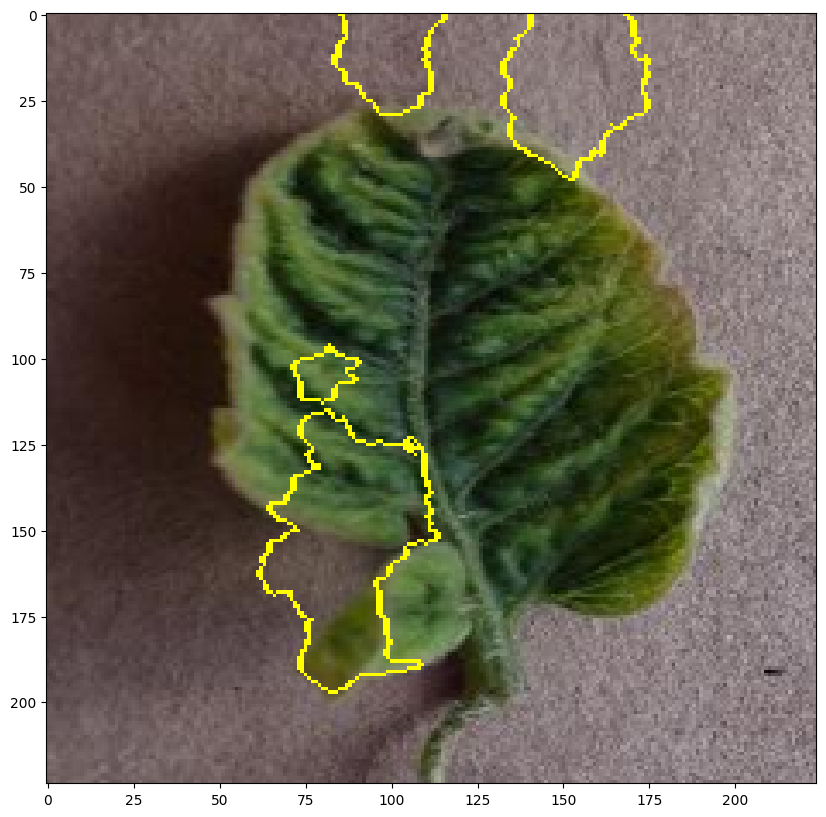

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus


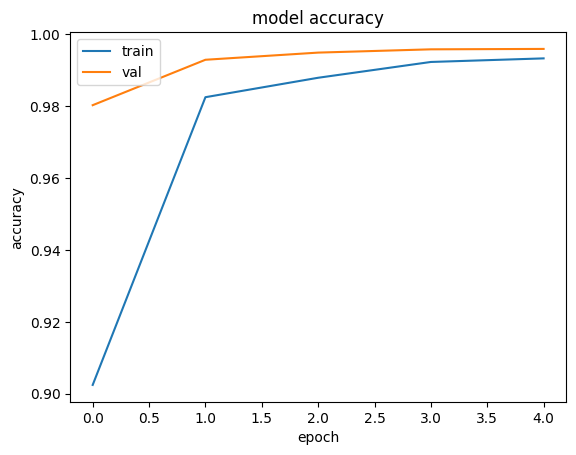

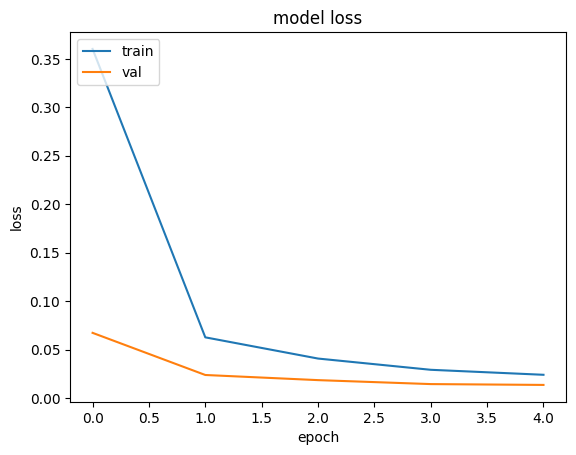

In [11]:
# Example Usage
predict_and_explain('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus2.JPG') #replace with your image.

# Plotting Training History
plt.plot(history_Final.history['accuracy'])
plt.plot(history_Final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_Final.history['loss'])
plt.plot(history_Final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
%%writefile model_utils.py
import tensorflow as tf
import numpy as np
from PIL import Image

def load_model(model_path):
    """Loads a TensorFlow/Keras model."""
    return tf.keras.models.load_model(model_path)

def predict_class(model, img_array):
    """Predicts the class of an image."""
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    return predicted_class_index

Writing model_utils.py


In [13]:
%%writefile lime_utils.py
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np

def lime_explain(img_array, model):
    """Generates a LIME explanation for an image."""
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array.astype('double'),
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    img_boundry = mark_boundaries(temp / 255.0, mask)
    return img_boundry

Writing lime_utils.py


In [14]:
%%writefile app.py
import streamlit as st
from PIL import Image
import numpy as np
from model_utils import load_model, predict_class
from lime_utils import lime_explain
import os

# Load Model and Class Dictionary
model_path = 'Plant_Village_Detection_Model_ACC99.53%.h5'
if not os.path.exists(model_path):
    st.error(f"Model not found at {model_path}")
    st.stop()
model = load_model(model_path)

# Create Class Dictionary (Replace with your actual class dict)
class_dict = {
    'Apple': 0,
    'Blueberry': 1,
    'Cherry': 2,
    'Corn': 3,
    'Grape': 4,
    'Orange': 5,
    'Peach': 6,
    'Bell Pepper': 7,
    'Potato': 8,
    'Soybean': 9,
    'Squash': 10,
    'Strawberry': 11,
    'Tomato': 12
}

# Inverse class dictionary for label lookup
inverse_class_dict = {v: k for k, v in class_dict.items()}

# Streamlit App
st.title('Plant Disease Classification with LIME')

# Plant Selection Dropdown
plant_names = list(class_dict.keys())
selected_plant = st.selectbox('Select a Plant', plant_names)

# Image Upload
uploaded_file = st.file_uploader('Upload an image...', type=['jpg', 'jpeg', 'png'])

if uploaded_file is not None:
    image = Image.open(uploaded_file).resize((224, 224))
    img_array = np.array(image) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Prediction
    predicted_class_index = predict_class(model, img_array_expanded)
    predicted_class = inverse_class_dict[predicted_class_index]
    st.write(f'Predicted Class: {predicted_class}')

    # LIME Explanation
    st.write('LIME Explanation:')
    lime_img = lime_explain(img_array, model)
    st.image(lime_img, caption='LIME Visualization', use_column_width=True)

    # Display Original Image
    st.write('Original Image:')
    st.image(image, caption='Uploaded Image', use_column_width=True)
else:
    st.write("Please upload an image.")

Writing app.py


In [15]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.9 MB/s eta 0:00:00


In [16]:
import subprocess
subprocess.Popen(['streamlit', 'run', 'app.py', '--server.port', '6006'])

<Popen: returncode: None args: ['streamlit', 'run', 'app.py', '--server.port...>